In [39]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, log_loss, auc, precision_recall_curve
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

from xgboost import XGBClassifier
from functools import partial

sns.set_style('whitegrid')

import warnings
warnings.filterwarnings("ignore")

# Data Loading

In [2]:
df = pd.read_csv('data/aug_train.csv')

In [53]:
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


# EDA

## Descriptive and Summary Statistics

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

Columns with missing values (we will handle them later):
* gender
* enrolled_university
* education_level
* major_discipline
* experience
* company_size
* company_type
* last_new_job

In [5]:
df.describe()

,enrollee_id,city_development_index,training_hours,target
count,19158.000000,19158.000000,19158.000000,19158.000000
mean,16875.358179,0.828848,65.366896,0.249348
std,9616.292592,0.123362,60.058462,0.432647
min,1.000000,0.448000,1.000000,0.000000
25%,8554.250000,0.740000,23.000000,0.000000
50%,16982.500000,0.903000,47.000000,0.000000
75%,25169.750000,0.920000,88.000000,0.000000
max,33380.000000,0.949000,336.000000,1.000000


Looks like our dataset is imbalanced. Let's check the target variable distribution.

Reminder:

#### Target
* 0 – Not looking for job change;
* 1 – Looking for a job change

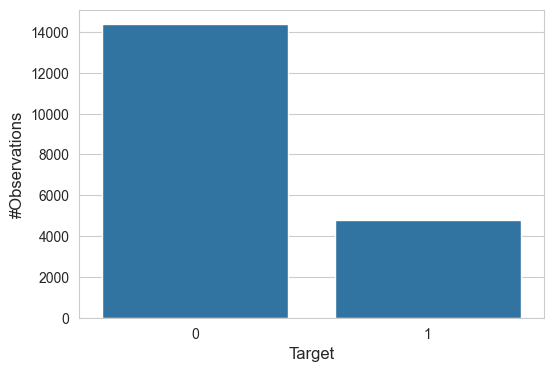

In [6]:
targets_count = df['target'].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(targets_count.values)
plt.ylabel('#Observations', fontsize=12)
plt.xlabel('Target', fontsize=12)
plt.xticks()
plt.show()

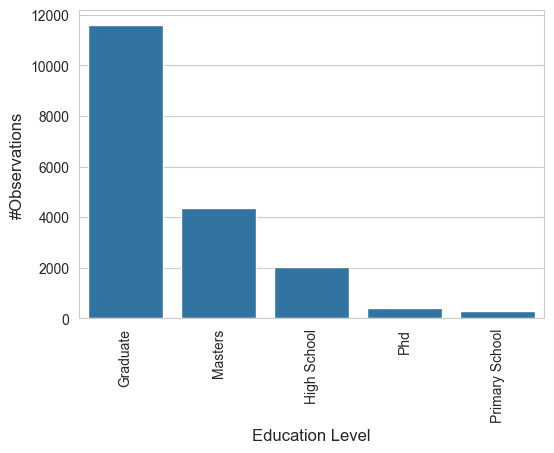

In [7]:
el_count = df['education_level'].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(el_count)
plt.ylabel('#Observations', fontsize=12)
plt.xlabel('Education Level', fontsize=12)
plt.xticks(rotation=90)
plt.show()

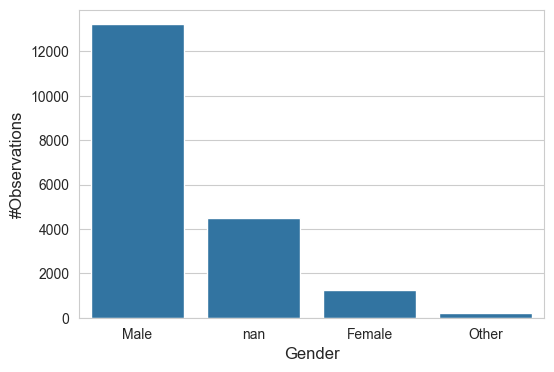

In [51]:
gender_count = df['gender'].value_counts(dropna=False)
plt.figure(figsize=(6,4))
sns.barplot(x=gender_count.index.astype(str), y=gender_count.values)
plt.ylabel('#Observations', fontsize=12)
plt.xlabel('Gender', fontsize=12)
plt.xticks()
plt.show()

Very imbalanced feature as well, with the majority of observations being Male or NaN.
Later on, we will replace NaN with 'Unknown' to create a new category. My gut feeling is that 'Other' refers to non-binary gender, whereas NaN refers to people who did not want to disclose their gender. They should therefore be treated differently.

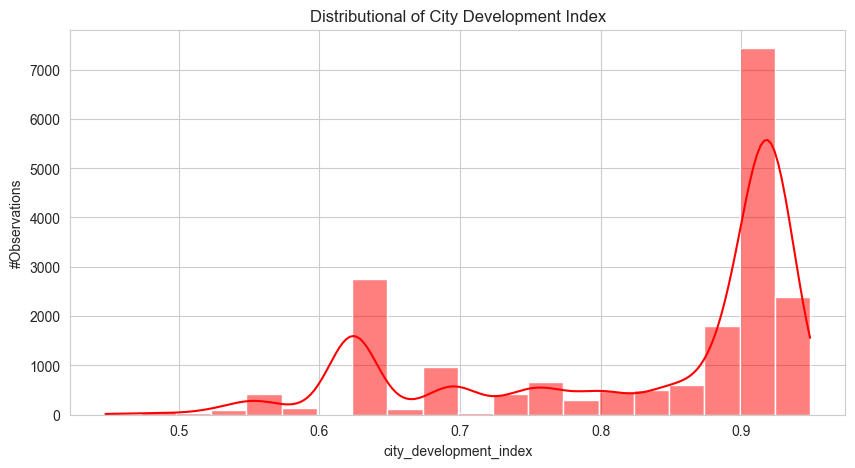

In [27]:
f, axes = plt.subplots(1, 1, figsize=(10, 5))
sns.histplot(df["city_development_index"], color="red", ax=axes, bins=20, kde=True)
axes.set_title("Distributional of City Development Index")
axes.set_ylabel("#Observations")
plt.show()

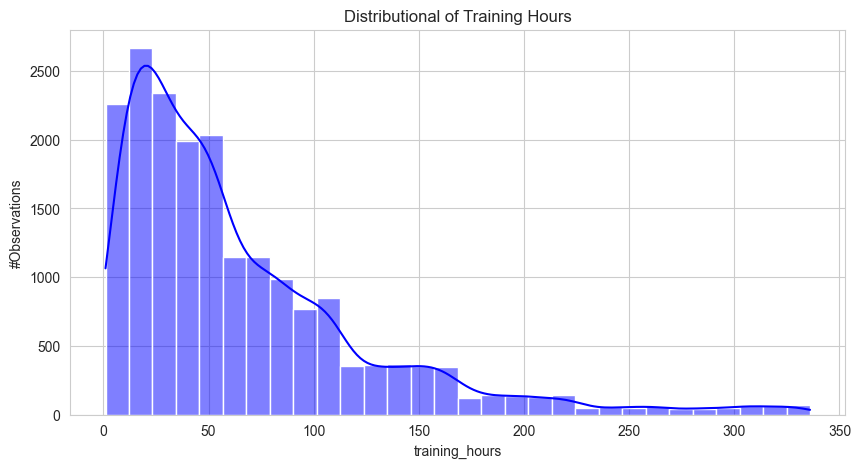

In [29]:
f, axes = plt.subplots(1, 1, figsize=(10, 5))
sns.histplot(df["training_hours"], color="blue", ax=axes, bins=30, kde=True)
axes.set_title("Distributional of Training Hours")
axes.set_ylabel("#Observations")
plt.show()

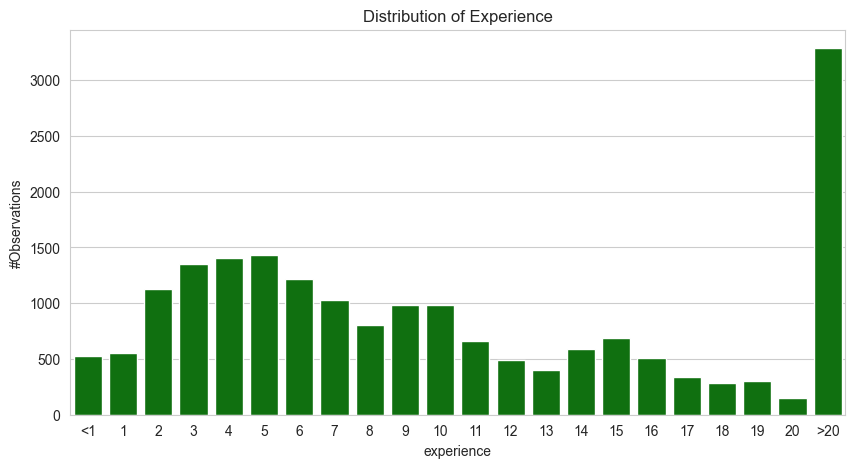

In [34]:
exp_order = ['<1', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '>20']
f, axes = plt.subplots(1, 1, figsize=(10, 5))
sns.countplot(x="experience", data=df, order=exp_order, color="green",
                ax=axes)
axes.set_title("Distribution of Experience")
axes.set_ylabel("#Observations")
plt.show()

## Correlation Analysis

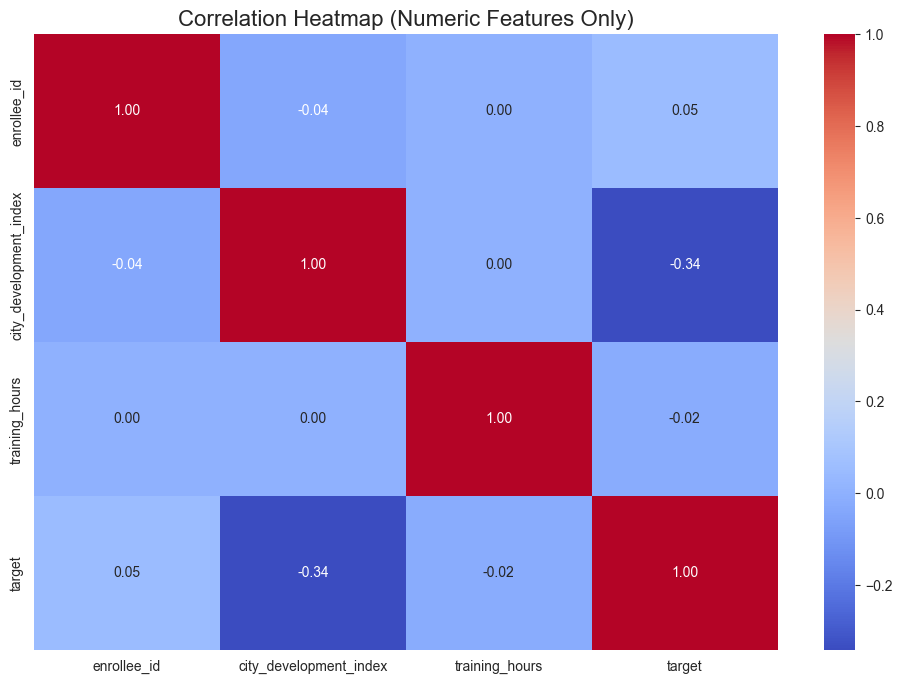

In [37]:
df_numeric = df.select_dtypes(include=['number'])

plt.figure(figsize=(12,8))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap (Numeric Features Only)', fontsize=16)
plt.show()

Very low correlation between features and target variable overall. CDI is the most correlated feature with target (-0.34). We will most likely need to engineer new features to improve model performance.

# Preprocessing

A part of preprocessing can be performed on the whole dataset before splitting, such as encoding categorical variables or fixing data types.

* target: Convert to integer type.
* enrollee_id: Convert to object type.
* experience: Values like >20 and <1 need to be mapped to numbers (e.g., 21 and 0, respectively) to allow the column to be treated as an ordinal integer feature.
* last_new_job: Values like 'never' and '>4' also represent an ordinal progression (number of years/jobs).
* city_development_index: has messy floating-point precision (e.g., 0.7759999999999999). While this doesn't affect model training, cleaning it improves readability.


In [ ]:
df['target'] = df['target'].astype(int)
df['enrollee_id'] = df['enrollee_id'].astype(str)

df['experience'] = df['experience'].replace({'<1': 0, '>20': 21}).astype(float)
df['last_new_job'] = df['last_new_job'].replace({'never': 0, '>4': 5}).astype(float)
df['city_development_index'] = df['city_development_index'].round(3)

## Data Splitting

Before we perform missing data imputation, we will split the data into train and validation sets to avoid data leakage.

In [40]:
# we stratify based on target variable to maintain class distribution in both sets
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['target'], random_state=7)

## Data Imputation